# Notebook to run CompVis Latent Diffusion using LAION-400M model

Latent Diffusion and pretrained model from [
CompVis Heidelberg](https://hci.iwr.uni-heidelberg.de/) added PLMS support from [@RiversHaveWings](https://twitter.com/RiversHaveWings). 

Lovingly assembled into a Colab notebook with UI and Google Drive support for **you** by [@pharmapsychotic](https://twitter.com/pharmapsychotic)

If you want to check out lots of other notebooks and Ai art tools check out: https://pharmapsychotic.com/tools.html


# 1. Set Up

In [1]:
#@title 1.1 Check GPU
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-e1ad42d5-2375-4224-637e-8cda55ded085)


In [2]:
#@title 1.2 Mount Google Drive
#@markdown Your outputs will be saved on your Google Drive to AI/Latent_Diffusion

#@markdown If you enable saving models you can avoid the download times each session. Models will be put in AI/models

from google.colab import drive
drive.mount('/content/gdrive')


save_models_to_google_drive = False #@param {type:"boolean"}

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/models/ldm/text2img-large"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Diffusion"
!mkdir -p $model_path
!mkdir -p $outputs_path


Mounted at /content/gdrive


Install all the requirements

In [ ]:
#@title 1.3 Install libraries
!git clone https://github.com/pharmapsychotic/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

In [ ]:
#@title 1.4 Download models (5.7 GB)
%cd /content/latent-diffusion

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:    
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt


In [5]:
#@title 1.5 Define code

import argparse, os, sys, glob
import gc
import json
import numpy as np
import random
import torch

from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange
from torchvision.utils import make_grid

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

batch_index = 0

def run(opt):
    if opt.seed != -1:
        np.random.seed(opt.seed)
        random.seed(opt.seed)
        torch.manual_seed(opt.seed)
        torch.cuda.manual_seed_all(opt.seed)
        torch.backends.cudnn.deterministic = True

    config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml")  # TODO: Optionally download from same location as ckpt and chnage this logic
    model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

    if opt.plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt

    sample_path = outpath
    os.makedirs(sample_path, exist_ok=True)
    base_count = 0

    all_samples=list()
    with torch.no_grad():
        with model.ema_scope():
            uc = None
            if opt.scale > 0:
                uc = model.get_learned_conditioning(opt.n_samples * [""])
            for n in range(opt.n_iter):
                c = model.get_learned_conditioning(opt.n_samples * [prompt])
                shape = [4, opt.H//8, opt.W//8]
                samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                 conditioning=c,
                                                 batch_size=opt.n_samples,
                                                 shape=shape,
                                                 verbose=False,
                                                 unconditional_guidance_scale=opt.scale,
                                                 unconditional_conditioning=uc,
                                                 eta=opt.ddim_eta)

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                for x_sample in x_samples_ddim:
                    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                    Image.fromarray(x_sample.astype(np.uint8)).save(os.path.join(sample_path, f"{batch_name}({batch_index})_{base_count:04}.png"))
                    base_count += 1
                all_samples.append(x_samples_ddim)


    # show grid of results
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    if opt.save_grid:
        Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))


# 2. Run the diffusion!

Loading model from /content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Data shape for PLMS sampling is (4, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Data shape for PLMS sampling is (4, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


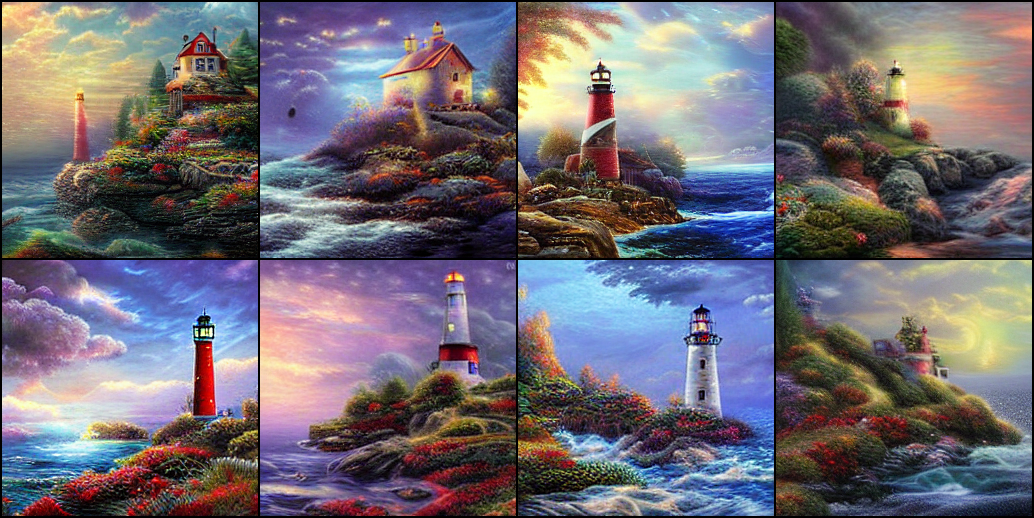

In [11]:
#@markdown Results saved to AI/Latent_Diffusion/`batch_name`

#@markdown The native resolution of the model is 256x256 but you can change `width_height` for larger dimensions than the network was trained for.

#@markdown `samples_per_batch` is how many images are generated in parallel. 4 is a good default for 16GB VRAM on Colab P100/V100 GPU.

#@markdown Optionally `save_grid` let's you save grid image for the batch.

#@markdown 

#@markdown ---

#@markdown ####**Settings:**
batch_name = 'Lighthouse' #@param{type: 'string'}
width_height = [256, 256]#@param{type: 'raw'}
samples_per_batch =   4#@param{type: 'number'}
num_batches = 2 #@param{type: 'number'}
prompt = "A beautiful painting of a singular lighthouse, shining its light across a tumultuous sea of blood by greg rutkowski and thomas kinkade, Trending on artstation." #@param{type: 'string'}
save_grid = False #@param {type: 'boolean'}
#@markdown ---
random_seed = -1 #@param{type: 'number'}
diffusion_sampling_mode = 'plms' #@param ['ddim','plms']  
steps = 50#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
ddim_eta = 0.5 #@param{type: 'number'}
prompt_scale = 5.0 #@param{type: 'number'}

if random_seed == -1:
    random.seed()
    seed = random.randint(0, 2**32)
else:
    seed = random_seed

settings = {
    'prompt': prompt,
    'width': width_height[0],
    'height': width_height[1],
    'steps': steps,
    'ddim_eta': ddim_eta,
    'prompt_scale': prompt_scale,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'random_seed': seed
}
batch_path = f"{outputs_path}/{batch_name}"
!mkdir -p $batch_path
with open(f"{batch_path}/{batch_name}({batch_index})_settings.txt", "w+") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)

gc.collect()
torch.cuda.empty_cache()

import argparse
args = argparse.Namespace(
    prompt = prompt,
    outdir = f"{outputs_path}/{batch_name}",
    plms = diffusion_sampling_mode == 'plms',
    ddim_steps = steps,
    ddim_eta = ddim_eta if diffusion_sampling_mode == 'ddim' else 0,
    n_iter = num_batches,
    W = width_height[0],
    H = width_height[1],    
    n_samples = samples_per_batch,
    scale = prompt_scale,
    seed = seed,
    save_grid = save_grid
)
run(args)

batch_index += 1